In [17]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from textwrap import dedent

# URLs de los datos (repositorio oficial en GitHub)
URL_DATA = "https://raw.githubusercontent.com/alura-cursos/challenge2-data-science-LATAM/main/TelecomX_Data.json"
URL_DICT = "https://raw.githubusercontent.com/alura-cursos/challenge2-data-science-LATAM/main/TelecomX_diccionario.md"

CLEAN_CSV = Path('TelecomX_clean.csv')
REPORT_MD = Path('TelecomX_report.md')

#📌 Extracción

In [7]:
response = requests.get(URL_DATA)
data_json = response.json()

# Para poder convertir a DataFrame
df_raw = pd.json_normalize(data_json)
print("Filas x Columnas (en bruto):", df_raw.shape)
df_raw.head()


Filas x Columnas (en bruto): (7267, 21)


,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


#🔧 Transformación

In [8]:
schema_info = pd.DataFrame({
    "columna": df_raw.columns,
    "dtype": [df_raw[c].dtype for c in df_raw.columns],
    "n_null": [df_raw[c].isna().sum() for c in df_raw.columns],
    "n_unique": [df_raw[c].nunique(dropna=False) for c in df_raw.columns],
})
schema_info.head(30)

,columna,dtype,n_null,n_unique
0,customerID,object,0,7267
1,Churn,object,0,3
2,customer.gender,object,0,2
3,customer.SeniorCitizen,int64,0,2
4,customer.Partner,object,0,2
5,customer.Dependents,object,0,2
6,customer.tenure,int64,0,73
7,phone.PhoneService,object,0,2
8,phone.MultipleLines,object,0,3
9,internet.InternetService,object,0,3


In [19]:

try:
    dict_text = requests.get(URL_DICT, timeout=30).text
except Exception as e:
    try:
        from pathlib import Path
        DICT_MD = Path('TelecomX_diccionario.md')
        dict_text = DICT_MD.read_text(encoding='utf-8')
    except Exception as e2:
        dict_text = f"(No se pudo leer el diccionario: {e} / {e2})"


rename_map = {
    'customerID': 'customerID',
    'Churn': 'Churn',
    'customer.gender': 'gender',
    'customer.SeniorCitizen': 'SeniorCitizen',
    'customer.Partner': 'Partner',
    'customer.Dependents': 'Dependents',
    'customer.tenure': 'tenure',
    'phone.PhoneService': 'PhoneService',
    'phone.MultipleLines': 'MultipleLines',
    'internet.InternetService': 'InternetService',
    'internet.OnlineSecurity': 'OnlineSecurity',
    'internet.OnlineBackup': 'OnlineBackup',
    'internet.DeviceProtection': 'DeviceProtection',
    'internet.TechSupport': 'TechSupport',
    'internet.StreamingTV': 'StreamingTV',
    'internet.StreamingMovies': 'StreamingMovies',
    'account.Contract': 'Contract',
    'account.PaperlessBilling': 'PaperlessBilling',
    'account.PaymentMethod': 'PaymentMethod',
    'account.Charges.Monthly': 'MonthlyCharges',
    'account.Charges.Total': 'TotalCharges',
}
df = df_raw.rename(columns=rename_map)


for col in ['MonthlyCharges', 'TotalCharges']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')


df['Churn'] = df['Churn'].replace({'': np.nan})

def standardize_service_flags(frame):
    frame = frame.copy()

    if 'PhoneService' in frame:
        no_phone = frame['PhoneService'].fillna('No').eq('No')
        if 'MultipleLines' in frame:
            frame.loc[frame['MultipleLines'].isin(['No phone service']), 'MultipleLines'] = 'No'
            frame.loc[no_phone, 'MultipleLines'] = 'No'

    if 'InternetService' in frame:
        no_internet = frame['InternetService'].fillna('No').eq('No')
        for c in ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']:
            if c in frame:
                frame[c] = frame[c].replace({'No internet service':'No'})
                frame.loc[no_internet, c] = 'No'
    return frame

df = standardize_service_flags(df)


dup_count = df.duplicated(subset=['customerID']).sum()
df = df.drop_duplicates(subset=['customerID'], keep='first')


mask_missing_total = df['TotalCharges'].isna() & df['MonthlyCharges'].notna() & df['tenure'].notna()
df.loc[mask_missing_total, 'TotalCharges'] = df.loc[mask_missing_total, 'MonthlyCharges'] * df.loc[mask_missing_total, 'tenure']


df['Cuentas_Diarias'] = df['MonthlyCharges'] / 30.0


yes_no_cols = ['Partner','Dependents','PhoneService','MultipleLines','OnlineSecurity','OnlineBackup',
               'DeviceProtection','TechSupport','StreamingTV','StreamingMovies','PaperlessBilling']
for c in yes_no_cols:
    if c in df.columns:
        df[c + '_bin'] = df[c].map({'Yes':1,'No':0})


df['Churn_bin'] = df['Churn'].map({'Yes':1,'No':0})
known_churn = df['Churn'].isin(['Yes','No'])


df.to_csv(CLEAN_CSV, index=False)
print("Duplicados eliminados:", int(dup_count))
print("Guardado limpio en:", CLEAN_CSV)
df.head()


Duplicados eliminados: 0
Guardado limpio en: TelecomX_clean.csv


,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,PhoneService_bin,MultipleLines_bin,OnlineSecurity_bin,OnlineBackup_bin,DeviceProtection_bin,TechSupport_bin,StreamingTV_bin,StreamingMovies_bin,PaperlessBilling_bin,Churn_bin
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,1,0,0,1,0,1,1,0,1,0.0
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,1,1,0,0,0,0,0,1,0,0.0
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,1,0,0,0,1,0,0,0,1,1.0
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,1,0,0,1,1,0,1,1,1,1.0
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,1,0,0,0,0,1,1,0,1,1.0


#📊 Carga y análisis

In [20]:
num_cols = ['tenure','MonthlyCharges','TotalCharges','Cuentas_Diarias'] + [c for c in df.columns if c.endswith('_bin')]
num_cols = [c for c in num_cols if c in df.columns]
desc = df[num_cols].describe().T
desc

,count,mean,std,min,25%,50%,75%,max
tenure,7267.0,32.346498,24.571773,0.000000,9.000000,29.000000,55.000000,72.000000
MonthlyCharges,7267.0,64.720098,30.129572,18.250000,35.425000,70.300000,89.875000,118.750000
TotalCharges,7267.0,2277.182035,2268.648587,0.000000,396.200000,1389.200000,3778.525000,8684.800000
Cuentas_Diarias,7267.0,2.157337,1.004319,0.608333,1.180833,2.343333,2.995833,3.958333
Partner_bin,7267.0,0.484106,0.499782,0.000000,0.000000,0.000000,1.000000,1.000000
Dependents_bin,7267.0,0.300124,0.458343,0.000000,0.000000,0.000000,1.000000,1.000000
PhoneService_bin,7267.0,0.902711,0.296371,0.000000,1.000000,1.000000,1.000000,1.000000
MultipleLines_bin,7267.0,0.421770,0.493876,0.000000,0.000000,0.000000,1.000000,1.000000
OnlineSecurity_bin,7267.0,0.285950,0.451897,0.000000,0.000000,0.000000,1.000000,1.000000
OnlineBackup_bin,7267.0,0.344571,0.475261,0.000000,0.000000,0.000000,1.000000,1.000000


In [21]:
churn_counts = df.loc[known_churn, 'Churn'].value_counts().sort_index()
churn_counts

,count
Churn,
No,5174
Yes,1869


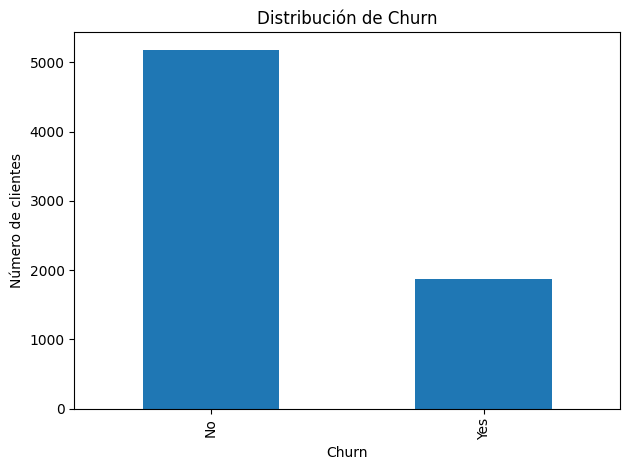

In [22]:
fig = plt.figure()
churn_counts.plot(kind='bar')
plt.title('Distribución de Churn')
plt.xlabel('Churn')
plt.ylabel('Número de clientes')
plt.tight_layout()
plt.show()

,churn_rate
gender,
Female,0.269209
Male,0.261603


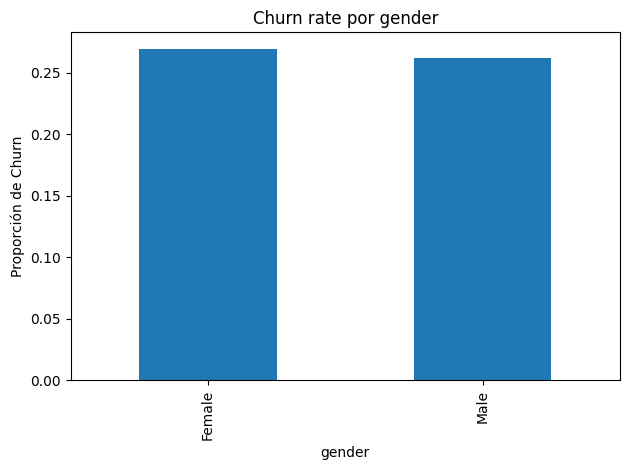

,churn_rate
Contract,
Month-to-month,0.427097
One year,0.112695
Two year,0.028319


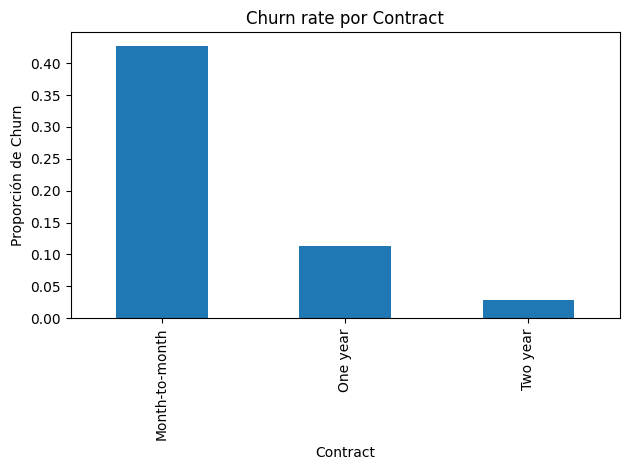

,churn_rate
PaymentMethod,
Electronic check,0.452854
Mailed check,0.191067
Bank transfer (automatic),0.167098
Credit card (automatic),0.152431


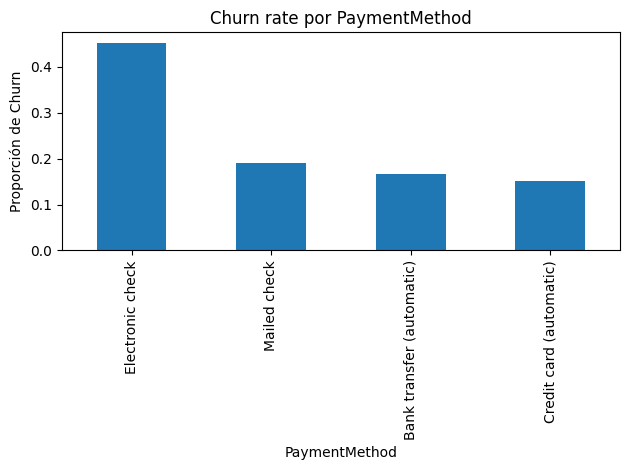

,churn_rate
PaperlessBilling,
Yes,0.335651
No,0.163301


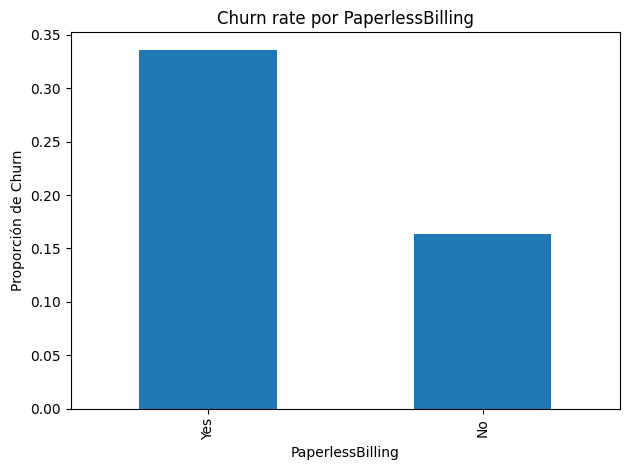

,churn_rate
InternetService,
Fiber optic,0.418928
DSL,0.189591
No,0.074050


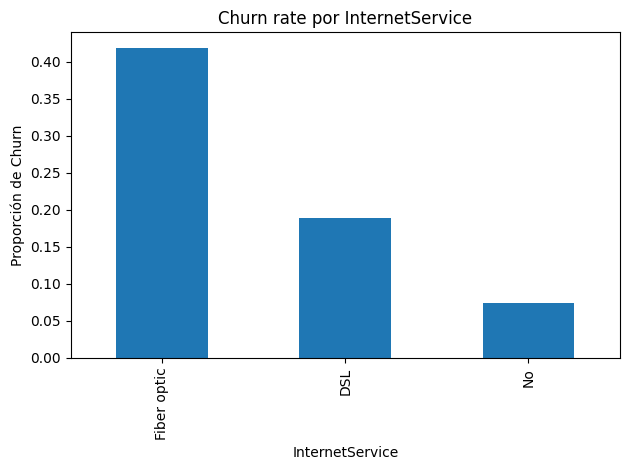

In [23]:
cat_cols = ['gender','Contract','PaymentMethod','PaperlessBilling','InternetService']
cat_cols = [c for c in cat_cols if c in df.columns]

category_churn_tables = {}
for c in cat_cols:
    tmp = (df.loc[known_churn].groupby(c)['Churn_bin'].mean().sort_values(ascending=False)
           .to_frame(name='churn_rate'))
    category_churn_tables[c] = tmp
    display(tmp)

    fig = plt.figure()
    tmp['churn_rate'].plot(kind='bar')
    plt.title(f'Churn rate por {c}')
    plt.ylabel('Proporción de Churn')
    plt.xlabel(c)
    plt.tight_layout()
    plt.show()

/tmp/ipython-input-4134042793.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=['No','Yes'])


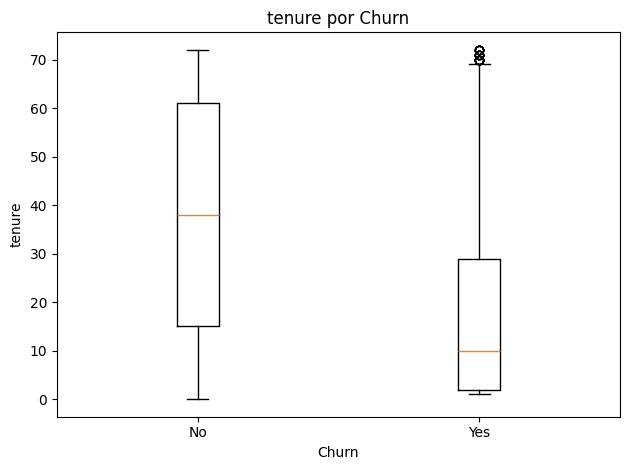

/tmp/ipython-input-4134042793.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=['No','Yes'])


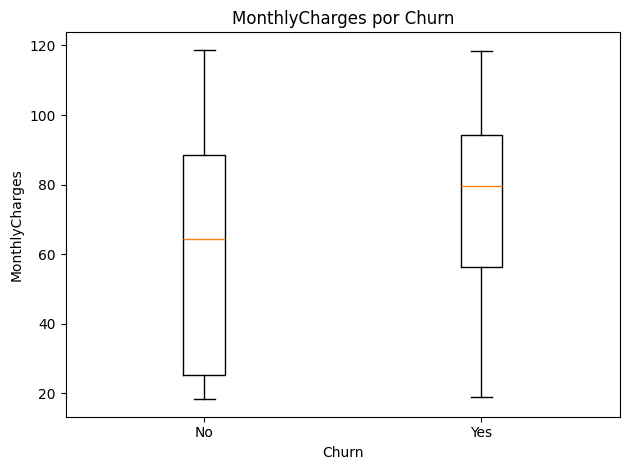

/tmp/ipython-input-4134042793.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=['No','Yes'])


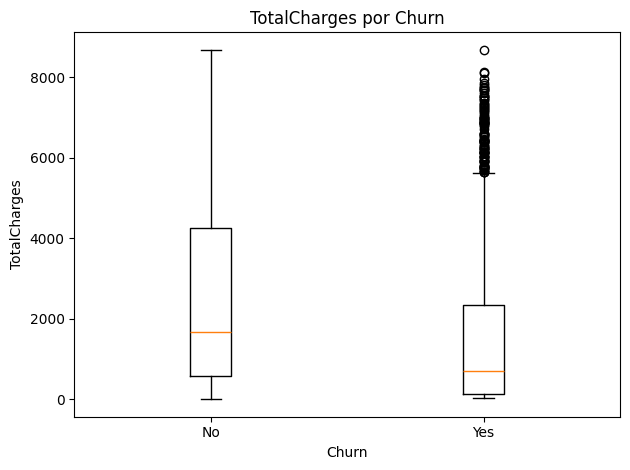

/tmp/ipython-input-4134042793.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=['No','Yes'])


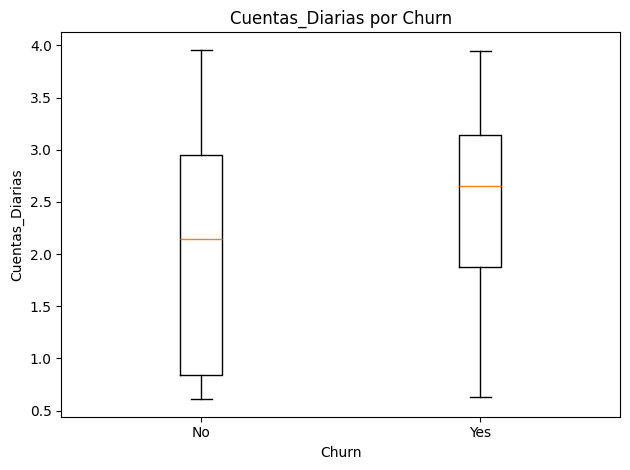

In [24]:
num_to_plot = ['tenure','MonthlyCharges','TotalCharges','Cuentas_Diarias']
num_to_plot = [c for c in num_to_plot if c in df.columns]

for c in num_to_plot:
    fig = plt.figure()
    data0 = df.loc[known_churn & (df['Churn']=='No'), c].dropna()
    data1 = df.loc[known_churn & (df['Churn']=='Yes'), c].dropna()
    plt.boxplot([data0, data1], labels=['No','Yes'])
    plt.title(f'{c} por Churn')
    plt.ylabel(c)
    plt.xlabel('Churn')
    plt.tight_layout()
    plt.show()

#📄Informe final

In [26]:
churn_rate = df.loc[known_churn, 'Churn_bin'].mean() if known_churn.any() else np.nan

def top_categories(table_dict, top_n=3):
    lines = []
    for feat, tbl in table_dict.items():
        head = tbl.head(top_n)
        for idx, row in head.iterrows():
            lines.append(f"- {feat} = {idx}: churn rate ≈ {row['churn_rate']:.2%}")
    return "\n".join(lines)

insights = dedent(f"""
- Tasa global de churn (registros conocidos): {churn_rate:.2%}.
- Tenure medio (meses): {df['tenure'].mean():.2f}; mediana: {df['tenure'].median():.2f}.
- Cargos mensuales — media: {df['MonthlyCharges'].mean():.2f}, mediana: {df['MonthlyCharges'].median():.2f}.
- TotalCharges — media: {df['TotalCharges'].mean():.2f}, mediana: {df['TotalCharges'].median():.2f}.
- Categorías con mayor churn observado (top 3 por variable):
{top_categories(category_churn_tables, top_n=3)}
""" ).strip()

report_text = dedent(f"""
# Informe final — TelecomX (Churn)

## Introducción
El objetivo es analizar la evasión de clientes (**Churn**) para entender patrones de comportamiento y oportunidades de retención.

## Datos y diccionario
- Fuente: JSON entregado (simula respuesta de API) → convertido a DataFrame mediante `pandas.json_normalize`.
- Diccionario de datos (resumen textual):
{dict_text}

## Limpieza y tratamiento
- Aplanado de estructura anidada y renombrado de columnas según el diccionario.
- Conversión de tipos: `MonthlyCharges` y `TotalCharges` a numérico (coacción de errores).
- Estándar de categorías: valores como "No internet service"/"No phone service" → se unifican a "No" en servicios dependientes.
- `Churn` vacío se transformó en **desconocido** (NaN) y se excluyó de métricas de churn.
- Eliminación de duplicados por `customerID` (encontrados y removidos: {int(dup_count)}).
- Imputación simple de `TotalCharges` cuando faltaba, usando `MonthlyCharges * tenure` si ambos estaban disponibles.
- Creación de **Cuentas_Diarias** = `MonthlyCharges / 30` (granularidad diaria).
- Binarización opcional de variables Sí/No para facilitar análisis (`*_bin`).

## Análisis exploratorio (EDA)
**Estadísticos descriptivos**: tenure, cargos mensuales, total y la métrica diaria.
**Distribución de Churn**: gráfico de barras sobre registros con churn conocido.
**Churn por categorías**: tasas por `gender`, `Contract`, `PaymentMethod`, `PaperlessBilling`, `InternetService`.
**Numéricos vs Churn**: boxplots de `tenure`, `MonthlyCharges`, `TotalCharges`, `Cuentas_Diarias` por estado de churn.

## Conclusiones e insights
{insights}

## Recomendaciones
1. Fidelización temprana en 3–6 meses (tenure bajo).
2. Incentivar contratos anuales/bianuales con descuentos.
3. Promover métodos de pago automáticos (menor fricción).
4. Bundles/valor agregado (seguridad/soporte) para clientes con cargos altos.
5. Alertas proactivas ante señales tempranas (p. ej., baja de add-ons).
""" )

# Guardar el informe
Path(REPORT_MD).write_text(report_text, encoding='utf-8')
print("Informe generado en:", REPORT_MD)

Informe generado en: TelecomX_report.md
